# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana0900s2"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5127, 32, 32, 3)
(5127, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(2))
model.summary()

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          12816     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 32)          0

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



C:\Users\Muell\anaconda3\envs\ct-make-py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
641/641 [==============================] - 22s 27ms/step - loss: 0.2899 - accuracy: 0.7277 - val_loss: 0.0212 - val_accuracy: 0.9435
Epoch 2/30
641/641 [==============================] - 10s 16ms/step - loss: 0.0244 - accuracy: 0.9579 - val_loss: 0.0148 - val_accuracy: 0.9591
Epoch 3/30
641/641 [==============================] - 10s 15ms/step - loss: 0.0132 - accuracy: 0.9690 - val_loss: 0.0104 - val_accuracy: 0.9552
Epoch 4/30
641/641 [==============================] - 9s 14ms/step - loss: 0.0083 - accuracy: 0.9723 - val_loss: 0.0087 - val_accuracy: 0.9747
Epoch 5/30
641/641 [==============================] - 10s 15ms/step - loss: 0.0064 - accuracy: 0.9753 - val_loss: 0.0051 - val_accuracy: 0.9766
Epoch 6/30
641/641 [==============================] - 10s 15ms/step - loss: 0.0050 - accuracy: 0.9803 - val_loss: 0.0033 - val_accuracy: 0.9795
Epoch 7/30
641/641 [==============================] - 10s 15ms/step - loss: 0.0040 - accuracy: 0.9861 - val_loss: 0.0026 - val_accuracy: 

### Step 1: Learing result
 
* Visualization of the training and validation results

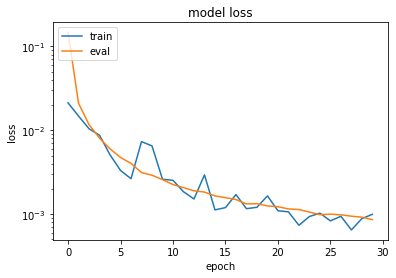

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
  5/641 [..............................] - ETA: 8s - loss: 0.5074 - accuracy: 0.6500 

C:\Users\Muell\anaconda3\envs\ct-make-py38-tf24\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


641/641 [==============================] - 11s 18ms/step - loss: 0.0620 - accuracy: 0.9198 - val_loss: 0.0174 - val_accuracy: 0.9454
Epoch 2/160
641/641 [==============================] - 11s 17ms/step - loss: 0.0122 - accuracy: 0.9670 - val_loss: 0.0089 - val_accuracy: 0.9669
Epoch 3/160
641/641 [==============================] - 12s 18ms/step - loss: 0.0079 - accuracy: 0.9707 - val_loss: 0.0066 - val_accuracy: 0.9727
Epoch 4/160
641/641 [==============================] - 12s 18ms/step - loss: 0.0060 - accuracy: 0.9754 - val_loss: 0.0086 - val_accuracy: 0.9727
Epoch 5/160
641/641 [==============================] - 11s 18ms/step - loss: 0.0054 - accuracy: 0.9787 - val_loss: 0.0064 - val_accuracy: 0.9688
Epoch 6/160
641/641 [==============================] - 11s 17ms/step - loss: 0.0044 - accuracy: 0.9780 - val_loss: 0.0036 - val_accuracy: 0.9776
Epoch 7/160
641/641 [==============================] - 11s 18ms/step - loss: 0.0038 - accuracy: 0.9803 - val_loss: 0.0054 - val_accuracy: 0.97

641/641 [==============================] - 10s 16ms/step - loss: 9.6229e-04 - accuracy: 0.9912 - val_loss: 9.1085e-04 - val_accuracy: 0.9805
Epoch 58/160
641/641 [==============================] - 10s 16ms/step - loss: 9.6868e-04 - accuracy: 0.9922 - val_loss: 9.3667e-04 - val_accuracy: 0.9893
Epoch 59/160
641/641 [==============================] - 10s 16ms/step - loss: 9.3546e-04 - accuracy: 0.9928 - val_loss: 7.5639e-04 - val_accuracy: 0.9942
Epoch 60/160
641/641 [==============================] - 10s 15ms/step - loss: 9.5566e-04 - accuracy: 0.9934 - val_loss: 8.2940e-04 - val_accuracy: 0.9883
Epoch 61/160
641/641 [==============================] - 10s 15ms/step - loss: 9.4460e-04 - accuracy: 0.9924 - val_loss: 9.3056e-04 - val_accuracy: 0.9922
Epoch 62/160
641/641 [==============================] - 10s 15ms/step - loss: 9.4055e-04 - accuracy: 0.9932 - val_loss: 9.3713e-04 - val_accuracy: 0.9961
Epoch 63/160
641/641 [==============================] - 10s 15ms/step - loss: 9.2688e-04 

641/641 [==============================] - 10s 15ms/step - loss: 6.6529e-04 - accuracy: 0.9943 - val_loss: 8.9342e-04 - val_accuracy: 0.9893
Epoch 111/160
641/641 [==============================] - 10s 15ms/step - loss: 7.0639e-04 - accuracy: 0.9941 - val_loss: 6.0770e-04 - val_accuracy: 0.9961
Epoch 112/160
641/641 [==============================] - 10s 15ms/step - loss: 7.0640e-04 - accuracy: 0.9955 - val_loss: 8.7640e-04 - val_accuracy: 0.9932
Epoch 113/160
641/641 [==============================] - 10s 15ms/step - loss: 6.6747e-04 - accuracy: 0.9951 - val_loss: 5.5009e-04 - val_accuracy: 0.9951
Epoch 114/160
641/641 [==============================] - 10s 15ms/step - loss: 6.7079e-04 - accuracy: 0.9959 - val_loss: 0.0011 - val_accuracy: 0.9932
Epoch 115/160
641/641 [==============================] - 10s 15ms/step - loss: 6.8697e-04 - accuracy: 0.9936 - val_loss: 8.1792e-04 - val_accuracy: 0.9951
Epoch 116/160
641/641 [==============================] - 10s 15ms/step - loss: 6.6740e-0

### Overall Learing results (Step 1 & Step 2)

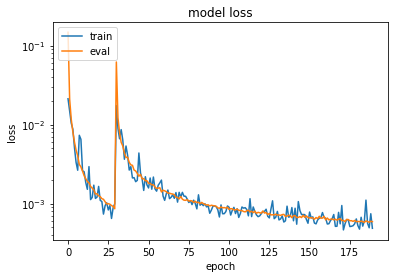

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in files:
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all\0.2_0098_zeiger1_2020-04-29_11-00-02.jpg 0.02 0.07412192909420384 -0.05412192909420384
data_resize_all\2.0_0944_zeiger4_2020-04-29_13-35-02.jpg 0.2 0.1240725112210234 0.0759274887789766
data_resize_all\2.0_0945_zeiger4_2020-04-29_13-53-02.jpg 0.2 0.14491673074808675 0.05508326925191326
data_resize_all\5.0_2520_zeiger4_2019-06-04T141009.jpg 0.5 0.4395838791743829 0.06041612082561709
data_resize_all\5.1_2571_zeiger4_2019-06-04T100009.jpg 0.51 0.43275494220571803 0.07724505779428198
data_resize_all\5.2_2608_zeiger4_2019-06-02T180009.jpg 0.52 0.455554834619633 0.06444516538036704
data_resize_all\5.4_2691_zeiger4_2019-06-02T202009.jpg 0.54 0.4653851843825738 0.07461481561742622
data_resize_all\6.1_3006_zeiger1_2020-04-29_11-47-02.jpg 0.61 0.6650661163953153 -0.055066116395315334
data_resize_all\6.2_3049_zeiger1_2020-04-29_14-26-02.jpg 0.62 0.6719536412088607 -0.0519536412088607
data_resize_all\6.5_3121_zeiger1_2020-04-29_13-07-02.jpg 0.65 0.7031666191329389 -0.05316661913293

## Results

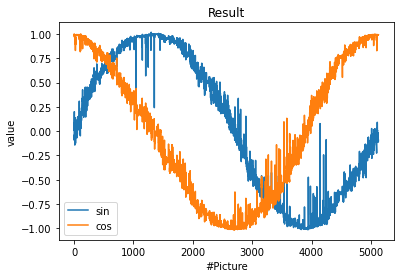

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

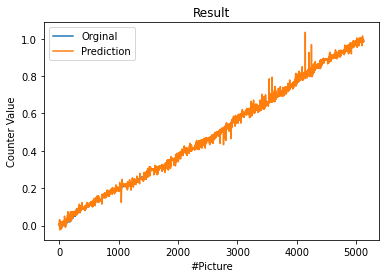

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

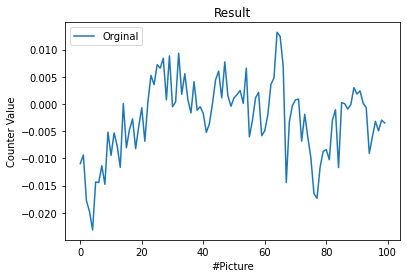

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

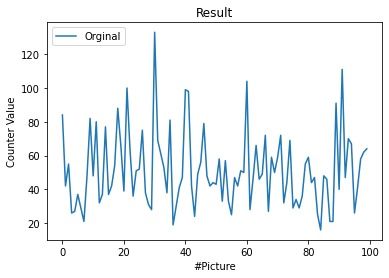

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

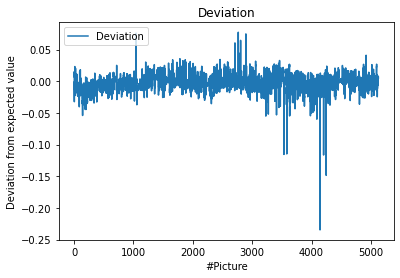

[-0.0021  0.0133 -0.2347  0.0772]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [19]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpzv_997p6\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmpzv_997p6\assets


134636

In [20]:
from pathlib import Path
import tensorflow as tf

FileName = TFliteNamingAndVersion + ".tflite"

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName, "wb").write(tflite_quant_model)
print(FileName)
Path(FileName).stat().st_size

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9je4gpt0\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp9je4gpt0\assets


ana0900s2.tflite


42448